## UKBB+HCP Modeling AutoML

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-12-10 16:19:58.110616: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 16:19:59.877437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 16:20:01.707354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

# sim imports
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [5]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 16.0%
RAM Usage: 6.1%
Available RAM: 945.7G
Total RAM: 1007.0G
52.4G


In [6]:
GPUtil.getAvailable()

[0]

### Load in structural connectomes

In [7]:
HCP_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/'
print(HCP_path)

# Load stuctural connectome from ENIGMA
HCP_enigma_structural_count = load_connectome(measure='SC')
HCP_enigma_structural_count_cortical = HCP_enigma_structural_count[:100, :100]

# Load 156-region structural connectivity matrices
HCP1200_S156_structural_count = np.log1p(loadmat(HCP_path + '/4S156/4S156_DTI_count.mat')['connectivity'])
HCP1200_S156_structural_count_cortical = HCP1200_S156_structural_count[:100, :100]
HCP1200_S156_structural_QA = loadmat(HCP_path + '/4S156/4S156_DTI_QA.mat')['connectivity']
HCP1200_S156_structural_QA_cortical = HCP1200_S156_structural_QA[:100, :100]

# Load 456-region structural connectivity matrices  
HCP1200_S456_structural_count = np.log1p(loadmat(HCP_path + '/4S456/4S456_DTI_count.mat')['connectivity'])
HCP1200_S456_structural_QA = loadmat(HCP_path + '/4S456/4S456_DTI_QA.mat')['connectivity']

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


### Load in functional connectomes

In [8]:
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_S156_functional_conn = pd.read_csv('./data/UKBB/UKBB_S156_functional_conn.csv')
UKBB_S156_functional_conn_cortical = np.array(UKBB_S156_functional_conn)[:100, :100]
UKBB_S156_labels = pd.read_csv('./data/UKBB/schaefer156_atlas_info.txt', sep='\t')['label_7network'].tolist()

UKBB_S456_functional_conn = pd.read_csv('./data/UKBB/UKBB_S456_functional_conn.csv')
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[:400, :400]
UKBB_S456_labels = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()

HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_enigma_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()


/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/


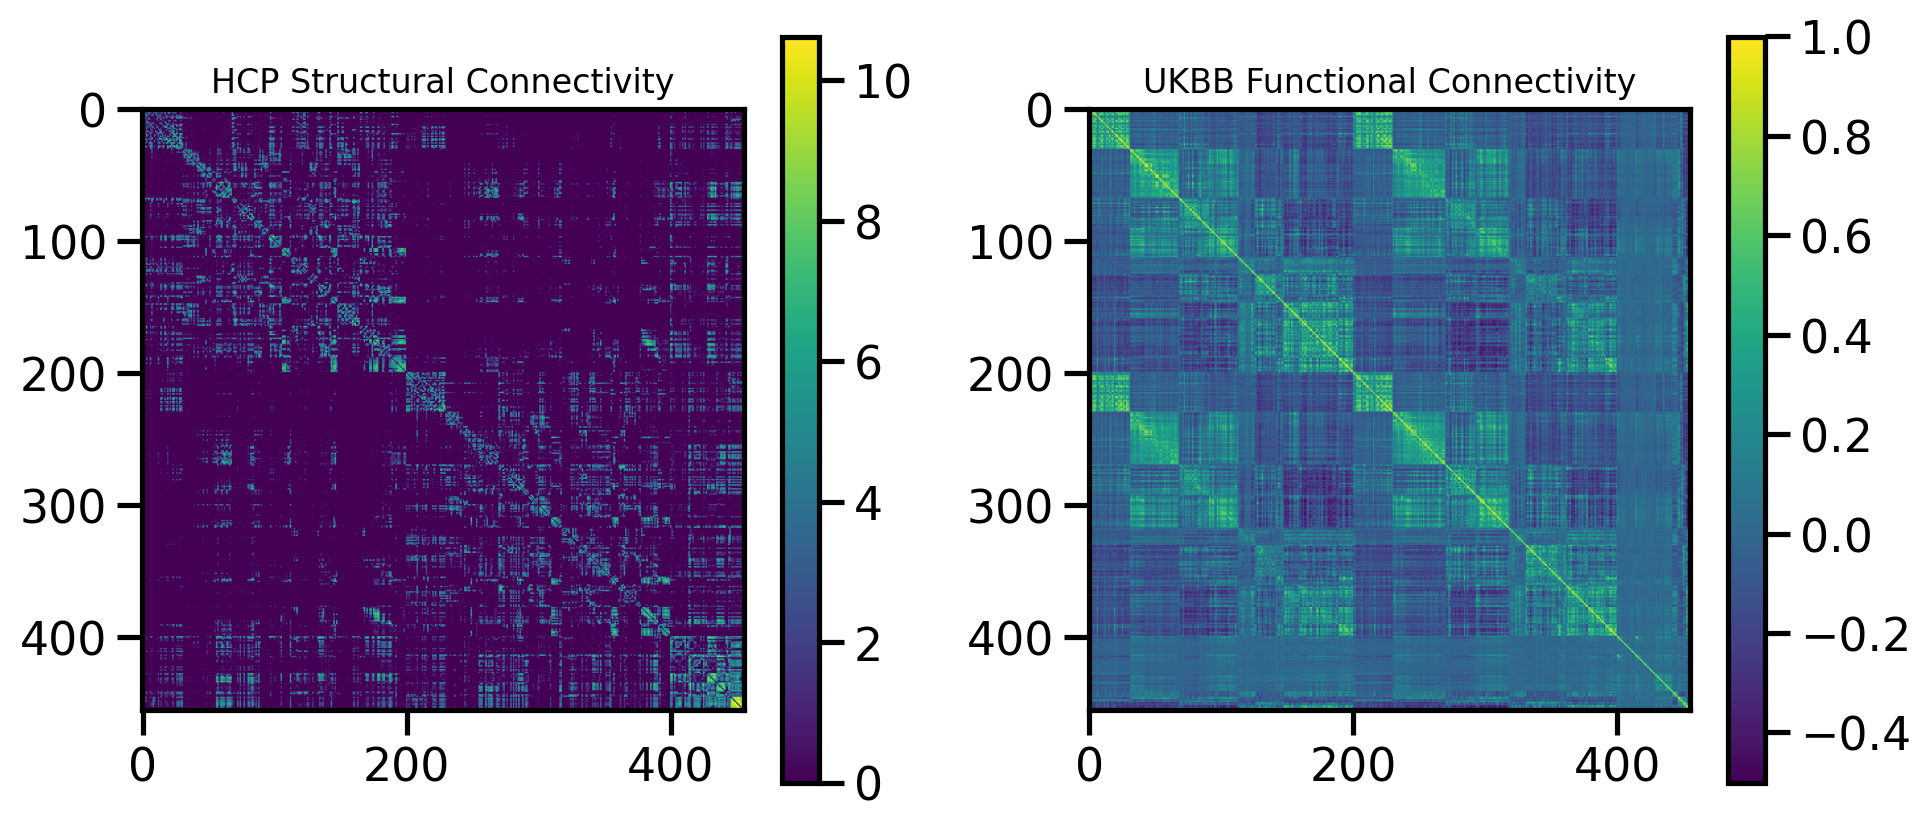

HCP Structure - UKBB Function Correlation: 0.180


In [9]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8), dpi=200)
plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('UKBB Functional Connectivity', fontsize=12)
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S456_structural_count).flatten(),
                              np.array(UKBB_S456_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


### Load in AHBA transcriptome

In [10]:
# Step 1: Load and preprocess AHBA gene expression data for Schaefer 456 parcellation
AHBA_UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/AHBA_population_MH/'
AHBA_S456_transcriptome = pd.read_csv(os.path.join(AHBA_UKBB_path, 'AHBA_schaefer456_mean.csv'))

# Step 2: Load and process atlas information
UKBB_S456_atlas_info_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/atlas_info/atlas-4S456Parcels_dseg_reformatted.csv'
UKBB_S456_atlas_info = pd.read_csv(UKBB_S456_atlas_info_path)

# Fill missing network labels
UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['label'].str.contains('Cerebellar', na=False)) & 
                         (UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Cerebellum'
UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Subcortex'

# Step 3: Handle missing values
nan_rows = AHBA_S456_transcriptome.isna().any(axis=1)
AHBA_S456_transcriptome = AHBA_S456_transcriptome[~nan_rows]
UKBB_S456_atlas_info = UKBB_S456_atlas_info[~nan_rows]

AHBA_S456_transcriptome = AHBA_S456_transcriptome.drop('label', axis=1)

# Step 4: Filter genes based on Schaefer 100 stable genes
genes_data = pd.read_csv(f"./data/enigma/allgenes_stable_r0.2_schaefer_400.csv")
genes_list = genes_data.columns.tolist()
genes_list.remove('label')
AHBA_S456_transcriptome = AHBA_S456_transcriptome[genes_list]

# Step 5: Extract labels from atlas info
region_labels = UKBB_S456_atlas_info['label'].tolist()
network_labels = UKBB_S456_atlas_info['network_label'].tolist()
# Store MNI coordinates from atlas info as list of [x,y,z] coordinates
mni_coords = [[x, y, z] for x, y, z in zip(UKBB_S456_atlas_info['mni_x'], 
                                          UKBB_S456_atlas_info['mni_y'],
                                          UKBB_S456_atlas_info['mni_z'])]
                                          
# Step 6: Clean connectome data
HCP1200_S456_structural_count = HCP1200_S456_structural_count[~nan_rows][:, ~nan_rows]
UKBB_S456_functional_conn = np.array(UKBB_S456_functional_conn)[~nan_rows][:, ~nan_rows]

# Step 7: Filter cortical regions
cortical_mask = ~np.array([label in ['Subcortex', 'Cerebellum'] for label in network_labels])
AHBA_cortical_transcriptome = np.array(AHBA_S456_transcriptome)[cortical_mask]
cortical_network_labels = np.array(network_labels)[cortical_mask]
cortical_region_labels = np.array(region_labels)[cortical_mask]
cortical_mni_coords = np.array(mni_coords)[cortical_mask]

# Step 8: Create left and right hemisphere masks
left_hemi_mask = np.array([label.startswith('LH_') for label in cortical_region_labels])
left_network_labels = cortical_network_labels[left_hemi_mask]
left_region_labels = cortical_region_labels[left_hemi_mask]
left_mni_coords = cortical_mni_coords[left_hemi_mask]

right_hemi_mask = np.array([label.startswith('RH_') for label in cortical_region_labels])
right_network_labels = cortical_network_labels[right_hemi_mask]
right_region_labels = cortical_region_labels[right_hemi_mask]
right_mni_coords = cortical_mni_coords[right_hemi_mask]

# Apply cortical mask to connectivity matrices
HCP1200_S456_structural_count_cortical = np.array(HCP1200_S456_structural_count)[cortical_mask][:, cortical_mask]
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[cortical_mask][:, cortical_mask]

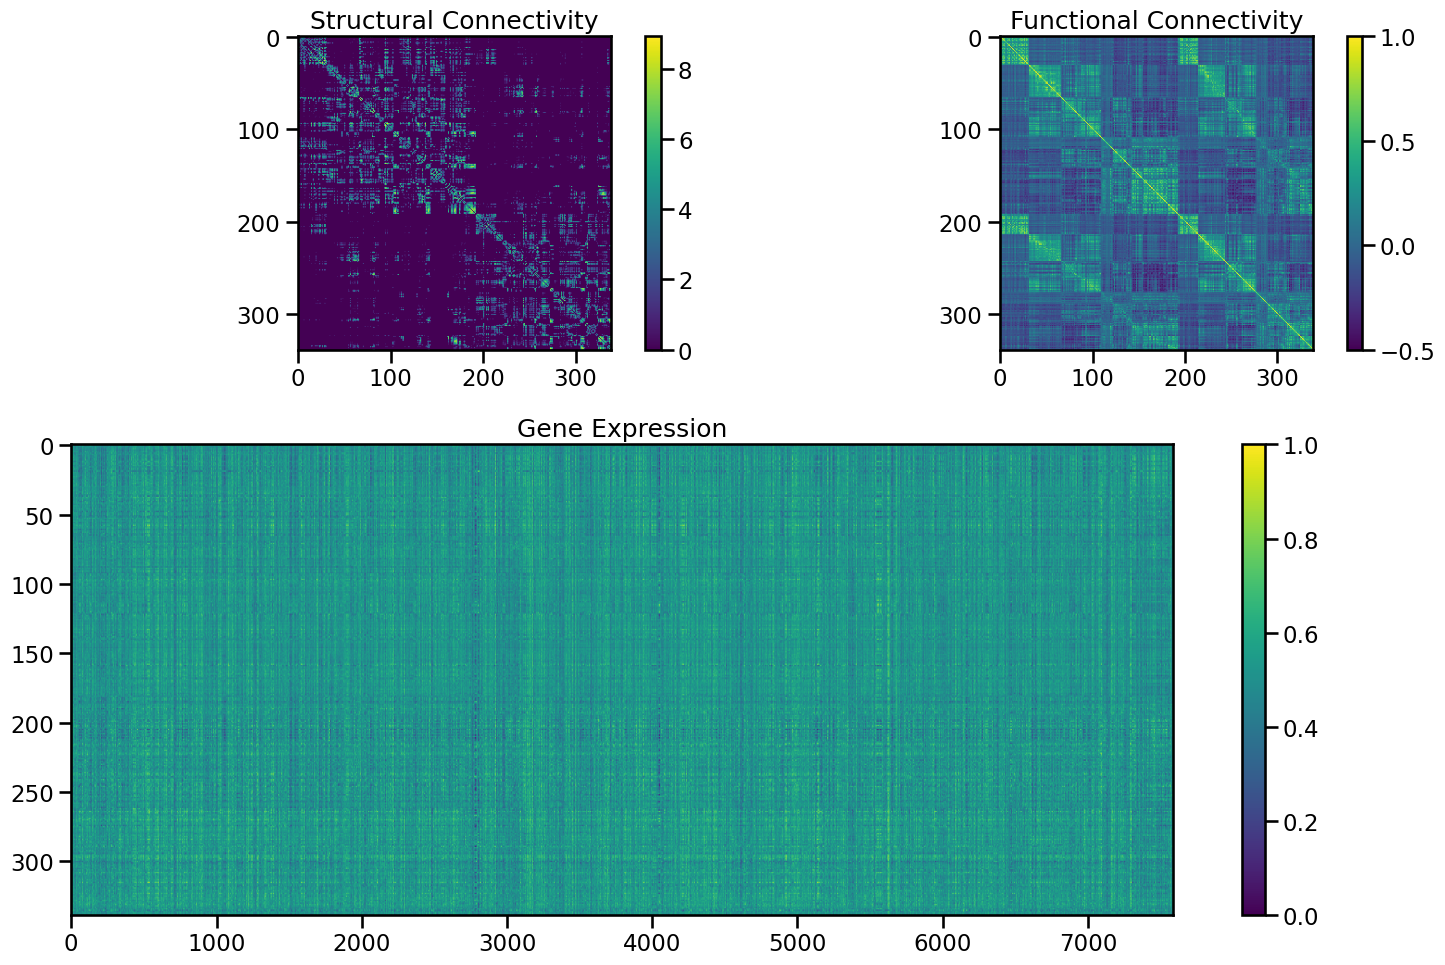

In [11]:
# Create two subplots - one for connectivity matrices and one for gene expression
fig = plt.figure(figsize=(15, 10))

# Create a gridspec layout with different heights
gs = plt.GridSpec(2, 2, height_ratios=[1, 1.5])

# Plot structural connectivity
ax1 = plt.subplot(gs[0, 0])
im1 = ax1.imshow(HCP1200_S456_structural_count_cortical, cmap='viridis')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

# Plot functional connectivity
ax2 = plt.subplot(gs[0, 1])
im2 = ax2.imshow(UKBB_S456_functional_conn_cortical, cmap='viridis')
ax2.set_title('Functional Connectivity')
plt.colorbar(im2, ax=ax2)

# Plot gene expression with elongated y-axis
ax3 = plt.subplot(gs[1, :])
im3 = ax3.imshow(AHBA_cortical_transcriptome, cmap='viridis', aspect='auto')
ax3.set_title('Gene Expression')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()


### Generate train (left hemisphere) and test (right hemisphere) sets  

In [17]:
# DIFFERS FROM GLM NOTEBOOK SINCE USING ALL GENES AS WELL
def construct_features_masked(X, Y_sc, Y_fc, mni_coords, mask_from, mask_to):
    """
    Construct features for GLM modeling from input data matrices using masks to specify regions.
    
    Args:
        X: Full gene expression data matrix (AHBA_cortical_transcriptome)
        Y_sc: Full structural connectivity matrix
        Y_fc: Full functional connectivity matrix  
        mni_coords: MNI coordinates for all regions
        mask_from: Boolean mask for source regions (e.g. cortical_mask, left_hemi_mask)
        mask_to: Boolean mask for target regions (e.g. cortical_mask, right_hemi_mask)
        
    Returns:
        Dictionary containing feature arrays and embeddings for the masked subset
    """
    # Get masked coordinates and connectivity matrices
    mni_coords_from = mni_coords[mask_from]
    mni_coords_to = mni_coords[mask_to]
    
    # Get masked connectivity matrices
    Y_sc_masked = Y_sc[mask_from][:, mask_to]
    Y_fc_masked = Y_fc[mask_from][:, mask_to]

    # Compute spectral embeddings using method 'A' on unmasked structural connectivity - NOTE THAT THIS VALUE IS TUNABLE
    _, eigenvectors = eig(Y_sc)  # Use unmasked Y_sc
    spectral_embeddings_from = eigenvectors[mask_from, :14]  # Apply mask_from after computing eigenvector 
    spectral_embeddings_to = eigenvectors[mask_to, :14]  # Apply mask_to after computing eigenvectors

    # Compute PCA from all gene expression data - determine components for 95% variance
    pca = PCA()
    X_pca_full = pca.fit_transform(X)  # Use unmasked X
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1

    # Get masked PCA components
    X_pca_masked_from = X_pca_full[mask_from]
    X_pca_masked_to = X_pca_full[mask_to]
    
    # Get masked gene expression
    X_masked_from = X[mask_from]
    X_masked_to = X[mask_to]

    # Calculate features between all pairs of masked regions
    num_from = len(mni_coords_from)
    num_to = len(mni_coords_to)
    
    distances = []
    sc_values = []
    fc_values = [] 
    gene_coexpression = []
    gene_PCA_coexpression = []
    spectral_similarity = []
    edge_PCA_embeddings = []
    edge_spectral_embeddings = []
    edge_mni_coords = []
    edge_genes = []

    for i in range(num_from):
        for j in range(num_to):
            # Skip self-connections if masks overlap
            if mask_from is mask_to and i >= j:
                continue
                
            # Calculate euclidean distance between regions i and j
            dist = np.sqrt(np.sum((mni_coords_from[i] - mni_coords_to[j])**2))
            distances.append(dist)
            
            # Get connectivity values between regions i and j
            sc_values.append(Y_sc_masked[i, j])
            fc_values.append(Y_fc_masked[i, j])
            
            # Calculate gene expression similarity
            gene_coexp = np.corrcoef(X_masked_from[i], X_masked_to[j])[0,1]
            gene_coexpression.append(gene_coexp)
            
            # Calculate PCA-based gene expression similarity
            gene_pca_coexp = np.corrcoef(X_pca_masked_from[i], X_pca_masked_to[j])[0,1]
            gene_PCA_coexpression.append(gene_pca_coexp)
            
            # Calculate spectral embedding similarity
            spec_sim = np.corrcoef(spectral_embeddings_from[i], spectral_embeddings_to[j])[0,1]
            spectral_similarity.append(spec_sim)
            
            # Store embeddings
            edge_PCA_embeddings.append(np.concatenate([X_pca_masked_from[i], X_pca_masked_to[j]]))
            edge_spectral_embeddings.append(np.concatenate([spectral_embeddings_from[i], spectral_embeddings_to[j]]))
            edge_mni_coords.append(np.concatenate([mni_coords_from[i], mni_coords_to[j]]))
            edge_genes.append(np.concatenate([X_masked_from[i], X_masked_to[j]]))

    # Convert lists to arrays
    features = {
        'distances': np.array(distances),
        'sc_values': np.array(sc_values),
        'fc_values': np.array(fc_values),
        'gene_coexpression': np.array(gene_coexpression),
        'gene_PCA_coexpression': np.array(gene_PCA_coexpression),
        'spectral_similarity': np.array(spectral_similarity),
        'edge_PCA_embeddings': np.array(edge_PCA_embeddings),
        'edge_spectral_embeddings': np.array(edge_spectral_embeddings),
        'edge_mni_coords': np.array(edge_mni_coords),
        'edge_genes': np.array(edge_genes)
    }
    
    return features

def prepare_data(features_dict, predictor_keys, target_key):
    """
    Prepare data for modeling by selecting specified predictor features and target variable.
    
    Parameters:
    -----------
    features_dict : dict
        Dictionary containing feature arrays
    predictor_keys : list
        List of keys for features to use as predictors
    target_key : str
        Key for the target variable
        
    Returns:
    --------
    X : ndarray
        Array of predictor features
    y : ndarray
        Array of target values
        
    Example:
    --------
    # Example using features from construct_features_masked()
    features = construct_features_masked(...)
    
    # Prepare data using distance and gene expression to predict FC
    predictor_keys = ['distances', 'gene_coexpression'] 
    X, y = prepare_data(features, predictor_keys, 'fc_values')
    
    # X will be a 2D array with distance and gene coexpression features
    # y will be a 1D array of FC values
    """
    # Initialize list to store predictor arrays
    X_list = []
    
    # Add each specified predictor feature
    for key in predictor_keys:
        if key not in features_dict:
            raise KeyError(f"Feature '{key}' not found in features dictionary")
            
        # Handle different shapes - reshape if needed
        feature = features_dict[key]
        if len(feature.shape) == 1:
            feature = feature.reshape(-1, 1)
        elif len(feature.shape) > 2:
            raise ValueError(f"Feature '{key}' has too many dimensions")
            
        X_list.append(feature)
    
    # Concatenate all predictor features
    X = np.hstack(X_list)
    
    # Get target variable
    if target_key not in features_dict:
        raise KeyError(f"Target '{target_key}' not found in features dictionary")
    y = features_dict[target_key]
    
    return X, y


In [18]:
left_hemisphere_features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=left_hemi_mask,
    mask_to=left_hemi_mask
)

right_hemisphere_features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=right_hemi_mask,
    mask_to=right_hemi_mask
)

Combined feature datasets

In [19]:
# Dataset version1 with 1D features only
predictor_keys = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
X_train_v1, y_train_v1 = prepare_data(left_hemisphere_features, predictor_keys, 'fc_values')
X_test_v1, y_test_v1 = prepare_data(right_hemisphere_features, predictor_keys, 'fc_values')

# Dataset version2 with 1D, low-D embeddings
predictor_keys = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
X_train_v2, y_train_v2 = prepare_data(left_hemisphere_features, predictor_keys, 'fc_values')
X_test_v2, y_test_v2 = prepare_data(right_hemisphere_features, predictor_keys, 'fc_values')

# Dataset version3 with 1D, low-D embeddings, complex features
predictor_keys = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords', 'edge_genes']
X_train_v3, y_train_v3 = prepare_data(left_hemisphere_features, predictor_keys, 'fc_values')
X_test_v3, y_test_v3 = prepare_data(right_hemisphere_features, predictor_keys, 'fc_values')


Related feature datasets

In [20]:
# Dataset version4 autocorrelation null
predictor_keys = ['distances', 'sc_values']
X_train_v4, y_train_v4 = prepare_data(left_hemisphere_features, predictor_keys, 'fc_values')
X_test_v4, y_test_v4 = prepare_data(right_hemisphere_features, predictor_keys, 'fc_values')
print("Training data shapes:")
print(f"X_train_v4 shape: {X_train_v4.shape}")
print(f"y_train_v4 shape: {y_train_v4.shape}")
print("Test data shapes:") 
print(f"X_test_v4 shape: {X_test_v4.shape}")
print(f"y_test_v4 shape: {y_test_v4.shape}")


# Dataset version5 with low-D genetics only
predictor_keys = ['gene_coexpression', 'gene_PCA_coexpression', 'edge_PCA_embeddings']
X_train_v5, y_train_v5 = prepare_data(left_hemisphere_features, predictor_keys, 'fc_values')
X_test_v5, y_test_v5 = prepare_data(right_hemisphere_features, predictor_keys, 'fc_values')
print("\nTraining data shapes:")
print(f"X_train_v5 shape: {X_train_v5.shape}")
print(f"y_train_v5 shape: {y_train_v5.shape}")
print("Test data shapes:") 
print(f"X_test_v5 shape: {X_test_v5.shape}")
print(f"y_test_v5 shape: {y_test_v5.shape}")

# Dataset version6 with raw genetics only
predictor_keys = ['edge_genes']
X_train_v6, y_train_v6 = prepare_data(left_hemisphere_features, predictor_keys, 'fc_values')
X_test_v6, y_test_v6 = prepare_data(right_hemisphere_features, predictor_keys, 'fc_values')
print("\nTraining data shapes:")
print(f"X_train_v6 shape: {X_train_v6.shape}")
print(f"y_train_v6 shape: {y_train_v6.shape}")
print("Test data shapes:") 
print(f"X_test_v6 shape: {X_test_v6.shape}")
print(f"y_test_v6 shape: {y_test_v6.shape}")

Training data shapes:
X_train_v4 shape: (18336, 2)
y_train_v4 shape: (18336,)
Test data shapes:
X_test_v4 shape: (10731, 2)
y_test_v4 shape: (10731,)

Training data shapes:
X_train_v5 shape: (18336, 680)
y_train_v5 shape: (18336,)
Test data shapes:
X_test_v5 shape: (10731, 680)
y_test_v5 shape: (10731,)

Training data shapes:
X_train_v6 shape: (18336, 15168)
y_train_v6 shape: (18336,)
Test data shapes:
X_test_v6 shape: (10731, 15168)
y_test_v6 shape: (10731,)


## AutoML

In [30]:
# select train and test 
version = 4
X_train, y_train = eval(f"X_train_v{version}"), eval(f"y_train_v{version}")
X_test, y_test = eval(f"X_test_v{version}"), eval(f"y_test_v{version}")

In [31]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# ElasticNetCV model with built-in cross-validation
elastic_net = ElasticNetCV(
    l1_ratio=[0, .01, .1, .5, .7, .9, .95, .99, 1],
    alphas=np.logspace(-4, 1, 50),
    cv=5,
    random_state=42
)

# Fit the model
elastic_net.fit(X_train, y_train)

# Get the best parameters
print(f"Best alpha: {elastic_net.alpha_:.4f}")
print(f"Best l1_ratio: {elastic_net.l1_ratio_:.4f}")

# Predictions using best model
elastic_net_preds = elastic_net.predict(X_test)

# Evaluation
mse_en = mean_squared_error(y_test, elastic_net_preds)
mae_en = mean_absolute_error(y_test, elastic_net_preds)
r2_en = r2_score(y_test, elastic_net_preds)
pearson_r_en, _ = pearsonr(y_test, elastic_net_preds)

# Output metrics
print("\nElasticNet Performance:")
print(f"RMSE: {mse_en ** 0.5:.4f}")
print(f"MSE: {mse_en:.4f}")
print(f"MAE: {mae_en:.4f}")
print(f"R^2: {r2_en:.4f}")
print(f"Pearson-r: {pearson_r_en:.4f}")

Best alpha: 0.1842
Best l1_ratio: 0.0000

ElasticNet Performance:
RMSE: 0.1827
MSE: 0.0334
MAE: 0.1417
R^2: 0.1661
Pearson-r: 0.4098


In [32]:
# XGBoost model with GPU acceleration
xgb_model = xgboost.XGBRegressor(
    tree_method='gpu_hist',  # Use GPU acceleration
    #gpu_id=0,               # GPU device ID
    max_depth=9,
    learning_rate=0.1,
    n_estimators=1000,
    early_stopping_rounds=20,
    random_state=42
)

# Fit the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# Get best iteration
print(f"Best iteration: {xgb_model.best_iteration}")

# Predictions using best model
xgb_preds = xgb_model.predict(X_test)

# Evaluation
mse_xgb = mean_squared_error(y_test_v1, xgb_preds)
mae_xgb = mean_absolute_error(y_test, xgb_preds)
r2_xgb = r2_score(y_test, xgb_preds)
pearson_r_xgb, _ = pearsonr(y_test, xgb_preds)

# Output metrics
print("\nXGBoost Performance:")
print(f"RMSE: {mse_xgb ** 0.5:.4f}")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R^2: {r2_xgb:.4f}")
print(f"Pearson-r: {pearson_r_xgb:.4f}")

[0]	validation_0-rmse:0.19625
[40]	validation_0-rmse:0.17996
Best iteration: 21

XGBoost Performance:
RMSE: 0.1794
MSE: 0.0322
MAE: 0.1386
R^2: 0.1965
Pearson-r: 0.4452


In [ ]:
from flaml import AutoML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Adjusted: Assume X_train and Y_train are larger training samples
# Assuming you have X_train and Y_train with increased sample size
# X_train_fold and Y_train_fold are subsets if needed for testing purposes

# Initialize FLAML AutoML
automl = AutoML()

# Configure FLAML with additional models and metrics
automl_settings = {
    "time_budget": 60,               # Total time in seconds
    "task": "regression",             # Specify the task type
    "metric": "rmse",                 # Optimize for RMSE
    "estimator_list": ['xgboost', 'rf', 'lrl1', 'lrl2'],
    "log_file_name": "flaml_log.txt", # Log file to record progress
    "seed": 42,                       # For reproducibility
}

# Train the AutoML model
automl.fit(X_train=X_train_fold, y_train=Y_train_fold, **automl_settings)

# Display the best model
print("Best model:", automl.best_estimator)
print("Best hyperparameters:", automl.best_config)

# Predict on the test set
predictions = automl.predict(X_test_fold)

# Evaluate performance
mse = mean_squared_error(Y_test_fold, predictions)
mae = mean_absolute_error(Y_test_fold, predictions)
r2 = r2_score(Y_test_fold, predictions)
pearson_r, _ = pearsonr(Y_test_fold, predictions)

# Output all metrics
print("\nPerformance Metrics:")
print(f"RMSE: {mse ** 0.5:.4f}")  # RMSE is the square root of MSE
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")
print(f"Pearson-r: {pearson_r:.4f}")

In [35]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
# Initialize H2O cluster
h2o.init(max_mem_size="8G", nthreads=4)

# Convert your training and testing data into H2O frames
X_train_fold_h2o = h2o.H2OFrame(X_train_fold)
Y_train_fold_h2o = h2o.H2OFrame(Y_train_fold.reshape(-1, 1))  # Reshape to a column
X_test_fold_h2o = h2o.H2OFrame(X_test_fold)
Y_test_fold_h2o = h2o.H2OFrame(Y_test_fold.reshape(-1, 1))    # Reshape to a column

# Combine X and Y for H2O AutoML
train_h2o = X_train_fold_h2o.cbind(Y_train_fold_h2o)
test_h2o = X_test_fold_h2o.cbind(Y_test_fold_h2o)

# Set the target column name
target = "target"
train_h2o.set_names(["feature_" + str(i) for i in range(X_train_fold.shape[1])] + [target])
test_h2o.set_names(["feature_" + str(i) for i in range(X_test_fold.shape[1])] + [target])

# Define the features and target
x = train_h2o.columns[:-1]  # Features
y = train_h2o.columns[-1]   # Target

# Run H2O AutoML
aml = H2OAutoML(
    max_models=40,          # Number of models to train
    max_runtime_secs=6000,   # Maximum runtime in seconds
    seed=42,                # For reproducibility
    sort_metric="RMSE",     # Optimize for regression metric
)

aml.train(x=x, y=y, training_frame=train_h2o)

# Evaluate the leaderboard
print("Leaderboard:")
print(aml.leaderboard)

# Predict on the test set
predictions = aml.predict(test_h2o)

# Convert predictions to a NumPy array for evaluation
predictions_np = h2o.as_list(predictions, use_pandas=True).values.flatten()
actuals_np = Y_test_fold

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE:", mean_squared_error(actuals_np, predictions_np))
print("MAE:", mean_absolute_error(actuals_np, predictions_np))
print("R^2:", r2_score(actuals_np, predictions_np))
print("Pearson-r:", pearsonr(actuals_np.flatten(), predictions_np.flatten()))

# Shut down H2O cluster
h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /ext3/miniconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /state/partition1/job-54353991/tmp0n_hw4rw
  JVM stdout: /state/partition1/job-54353991/tmp0n_hw4rw/h2o_asr655_started_from_python.out
  JVM stderr: /state/partition1/job-54353991/tmp0n_hw4rw/h2o_asr655_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_asr655_f1uag8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"
